# Motion Corrections in BART

This tutorial uses the [`BART`](http://mrirecon.github.io/bart/) command-line interface (CLI) and presents how to perform motion corrected reconstructions with BART.


## Outline
1. Bart Setup
2. Conventions in BART
3. Rigid body motion correction
4. Non-rigid motion fields for PICS


**Author**: [Moritz Blumenthal](mailto:blumenthal@@tugraz.at)

**Presenter**: [Moritz Blumenthal](mailto:blumenthal@@tugraz.at)

**Institution**: Institute of Biomedical Imaging, Graz University of Technology, Austria



## 1 Setup BART

This notebook is designed to run on a local system and on Google Colab. It uses the python kernel, however, almost all commands use the `%%bash` cell magic to be executed in a `bash` subshell.

### 1.1 Google Colab

To run BART on Google Colab, this notebook automatically installs dependencies and sets up the GPUs if the environment variable `COLAB=1`is set. If you run this notebook on your local system, you might not want this setup. Please set `COLAB=0` in this case. For a detailed explanation, see the [How to Run BART on Google Colaboratory](https://github.com/mrirecon/bart-workshop/tree/master/ismrm2021).

In [1]:
%env COLAB=1

env: COLAB=1


Not all GPUs on Google Colab support CUDA 11, we downgrade CUDA if necessary. Moreover, we install a version of cuda compatible with the driver. This might not be necessary when colab is updated. Please note that this process may take several minutes.

In [2]:
%%bash

[ $COLAB -ne 1 ] && echo "Skipp cell (not on Colab)" && exit 0

# Why Google?! As of May 13 cuda installed in colab (12.5) is incompatible with the driver (12.4)
# We install cuda 12.4 and link it here
apt install cuda-12-4

cd /usr/local
rm cuda
ln -s cuda-12.4 cuda

# Use CUDA 10.1 when on Tesla K80
GPU_NAME=$(nvidia-smi --query-gpu=gpu_name --format=csv,noheader)

if [ "Tesla K80" = "$GPU_NAME" ]; then
    echo "GPU type Tesla K80 does not support CUDA 11. Set CUDA to version 10.1."
    cd /usr/local; rm cuda; ln -s cuda-10.1 cuda
fi


Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  cuda-cccl-12-4 cuda-command-line-tools-12-4 cuda-compiler-12-4 cuda-crt-12-4
  cuda-cudart-12-4 cuda-cudart-dev-12-4 cuda-cuobjdump-12-4 cuda-cupti-12-4
  cuda-cupti-dev-12-4 cuda-cuxxfilt-12-4 cuda-demo-suite-12-4
  cuda-documentation-12-4 cuda-driver-dev-12-4 cuda-drivers cuda-drivers-575
  cuda-gdb-12-4 cuda-libraries-12-4 cuda-libraries-dev-12-4 cuda-nsight-12-4
  cuda-nsight-compute-12-4 cuda-nsight-systems-12-4 cuda-nvcc-12-4
  cuda-nvdisasm-12-4 cuda-nvml-dev-12-4 cuda-nvprof-12-4 cuda-nvprune-12-4
  cuda-nvrtc-12-4 cuda-nvrtc-dev-12-4 cuda-nvtx-12-4 cuda-nvvm-12-4
  cuda-nvvp-12-4 cuda-opencl-12-4 cuda-opencl-dev-12-4 cuda-profiler-api-12-4
  cuda-runtime-12-4 cuda-sanitizer-12-4 cuda-toolkit-12-4
  cuda-toolkit-12-4-config-common cuda-tools-12-4 cuda-visual-tools-12-4
  default-jre default-jre-headless dkms fakeroot fonts-dejavu-core
  fonts-

### 1.2 Install libraries

We install dependencies for BART. Make sure that you have installed the requirements if you run locally:

In [7]:
%%bash

[ $COLAB -ne 1 ] && echo "Skipp cell (not on Colab)" && exit 0

# As of May 13, 2024, the default gcc version in Colab is 11, bart requires gcc 12 so we explicitely install it

# Install BARTs dependencies
apt-get install -y make gcc-12 g++-12 libfftw3-dev liblapacke-dev libpng-dev libopenblas-dev time

Reading package lists...
Building dependency tree...
Reading state information...
libfftw3-dev is already the newest version (3.3.8-2ubuntu8).
liblapacke-dev is already the newest version (3.10.0-2ubuntu1).
libpng-dev is already the newest version (1.6.37-3build5).
make is already the newest version (4.3-4.1build1).
time is already the newest version (1.9-0.1build2).
libopenblas-dev is already the newest version (0.3.20+ds-1).
gcc-12 is already the newest version (12.3.0-1ubuntu1~22.04).
g++-12 is already the newest version (12.3.0-1ubuntu1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


### 1.3 Clone and Compile BART

We clone BART into the current working directory of this notebook and delete any previous installation in this directory.

In [8]:
%%bash

[ $COLAB -ne 1 ] && echo "Skipp cell (not on Colab)" && exit 0

# Clone Bart
[ -d bart ] && rm -r bart
git clone https://github.com/mrirecon/bart/ bart &> /dev/null

cd bart
git checkout 353af6a

# Define compile options
COMPILE_SPECS=" PARALLEL=1
                PARALLEL_NJOBS=16
                CUDA=1
                CC=gcc-12
                "

printf "%s\n" $COMPILE_SPECS > Makefiles/Makefile.local


if [ $COLAB -eq "1" ]
then
    # set path to cuda for Colab
    echo "CUDA_BASE=/usr/local/cuda" >> Makefiles/Makefile.local
    echo "CUDA_LIB=lib64" >> Makefiles/Makefile.local
fi

make


Your branch is up to date with 'origin/master'.
echo "#define MAIN_LIST affinereg, avg, bench, bin, bitmask, cabs, calc, caldir, calmat, carg, casorati, cc, ccapply, cdf97, circshift, conj, conv, conway, copy, cpyphs, creal, crop, delta, denoise, ecalib, ecaltwo, epg, estdelay, estdims, estmotion, estshift, estvar, extract, fakeksp, fft, fftmod, fftrot, fftshift, filter, flatten, flip, fmac, fovshift, grog, homodyne, ictv, index, interpolate, invert, itsense, join, looklocker, lrmatrix, mandelbrot, measure, mip, mnist, moba, mobafit, morphop, multicfl, ncalib, nlinv, nlinvnet, nlmeans, nnet, noise, normalize, nrmse, nufft, nufftbase, onehotenc, ones, pattern, phantom, pics, pocsense, poisson, pol2mask, poly, psf, raga, reconet, repmat, reshape, resize, rmfreq, rof, roistat, rovir, rss, rtnlinv, sake, saxpy, scale, sdot, show, signal, sim, slice, spow, sqpics, squeeze, ssa, std, stl, svd, tee, tensorflow, tgv, threshold, toimg, toraw, traj, transpose, trx, twixread, unwrap, upat, var, v

Already on 'master'
make[1]: warning: -j16 forced in makefile: resetting jobserver mode.
ar: creating lib/libbox.a
ar: creating lib/libgrecon.a
ar: creating lib/libsense.a
ar: creating lib/libnoir.a
ar: creating lib/libiter.a
ar: creating lib/liblinops.a
ar: creating lib/libwavelet.a
ar: creating lib/liblowrank.a
ar: creating lib/libnoncart.a
ar: creating lib/libcalib.a
ar: creating lib/libsimu.a
ar: creating lib/libsake.a
ar: creating lib/libnlops.a
ar: creating lib/libnetworks.a
ar: creating lib/libnn.a
ar: creating lib/libmoba.a
ar: creating lib/libgeom.a
ar: creating lib/libmotion.a
ar: creating lib/libstl.a
ar: creating lib/libnum.a
ar: creating lib/libmisc.a


### 1.4 Add BART to PATH variable

We add the BART directory to the PATH variable and include the python wrapper for reading *.cfl files:

In [13]:
import os
import sys

if os.environ["COLAB"] == "1":
	os.environ['BART_TOOLBOX_PATH']=os.getcwd()+"/bart/"

os.environ['PATH'] = os.environ['BART_TOOLBOX_PATH'] + ":" + os.environ['PATH']
sys.path.append(os.environ['BART_TOOLBOX_PATH'] + "/python/")

# Environment telling BART to use GPU if available
os.environ['BART_GPU']="1"
os.environ['BART_GPU_GLOBAL_MEMORY']="1"
os.environ['BART_DEBUG_LEVEL']="4"

Check BART setup:

In [10]:
%%bash

echo "# The BART used in this notebook:"
which bart
echo "# BART version: "
bart version

# The BART used in this notebook:
/content/bart//bart
# BART version: 
v0.9.00-878-g353af6a


In [11]:
%matplotlib inline

import cfl
import numpy as np
from matplotlib import pyplot as plt

def plot(files, names=None, title=None, shape=None, figsize=16, window=1., savepath=None):
	import numpy as np
	from matplotlib import pyplot as plt
	import cfl

	if shape is None:
		shape = (1, len(files))

	fig, axs = plt.subplots(shape[0], shape[1], squeeze=False, constrained_layout=True, figsize=(figsize, figsize * shape[0] / shape[1]))

	axs = axs.flatten()

	max = 0.

	for i, f in enumerate(files):
		dat = np.abs(cfl.readcfl(f)).squeeze()
		max = max if max > np.max(dat) else np.max(dat)

	for i, f in enumerate(files):
		dat = np.abs(cfl.readcfl(f)).squeeze()
		axs[i].imshow(dat,cmap = "gray", vmax=max * window)
		axs[i].set_title(f if title is None else title[i])
		axs[i].axis('off')

	if savepath is not None:
		plt.savefig(savepath)

	plt.show()


### 1.5 Download Required Data
We include the data download here, so it does not interrupt the flow of the tutorial later on. The data is shared on Zenodo:

In [12]:
%%bash

wget -nc -O ksp_ref.hdr https://zenodo.org/record/13585332/files/ksp_ref.hdr
wget -nc -O ksp_ref.cfl https://zenodo.org/record/13585332/files/ksp_ref.cfl

wget -nc -O ksp_mov.hdr https://zenodo.org/record/13585332/files/ksp_mov.hdr
wget -nc -O ksp_mov.cfl https://zenodo.org/record/13585332/files/ksp_mov.cfl

wget -nc -O ksp_lung.hdr https://zenodo.org/record/13585332/files/ksp_lung.hdr
wget -nc -O ksp_lung.cfl https://zenodo.org/record/13585332/files/ksp_lung.cfl


--2025-06-02 17:01:45--  https://zenodo.org/record/13585332/files/ksp_ref.hdr
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.48.194, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/13585332/files/ksp_ref.hdr [following]
--2025-06-02 17:01:46--  https://zenodo.org/records/13585332/files/ksp_ref.hdr
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 157 [application/octet-stream]
Saving to: ‘ksp_ref.hdr’

     0K                                                       100% 12.4K=0.01s

2025-06-02 17:01:46 (12.4 KB/s) - ‘ksp_ref.hdr’ saved [157/157]

--2025-06-02 17:01:46--  https://zenodo.org/record/13585332/files/ksp_ref.cfl
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.48.194, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiti

Check BART Setup (again):

In [45]:
%%bash

echo "# The BART used in this notebook:"
which bart
echo "# BART version: "
bart version -V

# The BART used in this notebook:
/content/bart//bart
# BART version: 
BART_VERSION=v0.9.00-878-g353af6a
GCC_VERSION=12.3.0
CUDA=1
ACML=0
FFTWTHREADS=1
OMP=1
TENSORFLOW=0
MPI=0


## 2 BART Conventions

### Definition of the nuDFT

$$
\begin{aligned}
\hat{f}(c_m)=\hat{f}_m
&= \frac{1}{\sqrt{N}}\sum_{|c_n| \le \frac{N}{2}}\exp\left(\frac{-2\pi i}{N}\left(n-\frac{N}{2}\right)c_m\right)f_n
\end{aligned}
$$

* $f_n$ values on the Cartesian grid (with center N/2)
* $c_m$ coordinates of the non-Cartesian sample points (trajectory)
* $\hat{f}_m$ k-Space data at k-Space coordinate $c_m$

For Cartesian trajectories, this definition is consistent with the centered unitary FFT. As the grid spacing of $f_n$ is measured in units $\frac{\text{FoV}}{N}$, the k-Space coordinates are measured in units $\frac{1}{\text{FoV}}$.

**Warning**: The definition varies for different toolboxes by scaling of the data and/or trajectory.

![title](https://github.com/mrirecon/bart-workshop/blob/master/ismrm_motion_2024/conventions.png?raw=1)

Grid to world transformation, i.e. transforming grid coordinates $(n_x, n_y, n_z)$ to world coordinates measured in units of FoV in the respective direction:
$$\begin{pmatrix}
\frac{1}{N_x} & 0 & 0 & -\frac{N_x//2}{N_x} \\
0 & \frac{1}{N_y} & 0 & -\frac{N_y//2}{N_y} \\
0 & 0 & \frac{1}{N_z} & -\frac{N_z//2}{N_z}
\end{pmatrix}
\begin{pmatrix}
n_x \\ n_y \\ n_z \\ 1
\end{pmatrix}
$$


### Basics of Image Registration
* $I_r(\vec{x}_r)$ - reference image
* $I_m(\vec{x}_m)$ - moved image
* $\Phi$ - coordinate transformation
* Registration: Find $\Phi$ such that $I_r(\vec{x}_r) = I_m(\vec{x}_m=\Phi(\vec{x}_r))$
* Rigid body motion: $\Phi(\vec{x}_r) = R\vec{x}_r + \vec{a}$
	* $R$ - rotation matrix around the origin
	* $\vec{a}$ - translation vector (units of FoV)
* Non-rigid motion: $\Phi(\vec{x}_r) = \vec{x}_r + \vec{u}(\vec{x}_r)$
	* $\vec{u}(\vec{x}_r)$ - displacement field units of grid points
	* vector components of $\vec{u}$ are stored in BART dimension 8

## 3 Rigid Body Motion Correction

$$I_r(\vec{x}_r) = I_m(R\vec{x}_r+\vec{a})\Rightarrow\mathcal{F}[I_r](R^T \vec{k}) = \exp(i2\pi \vec{a}\cdot \vec{k})\mathcal{F}[I_m](\vec{k})$$

1. Calibrationless reconstruction with NLINV
2. Rigid registration (affinereg)
3. Interpolation in image space
4. Correction in k-space

In [16]:
%%bash

wget -nc -O ksp_ref.hdr https://zenodo.org/record/13585332/files/ksp_ref.hdr
wget -nc -O ksp_ref.cfl https://zenodo.org/record/13585332/files/ksp_ref.cfl

wget -nc -O ksp_mov.hdr https://zenodo.org/record/13585332/files/ksp_mov.hdr
wget -nc -O ksp_mov.cfl https://zenodo.org/record/13585332/files/ksp_mov.cfl

bart show -m ksp_ref


Type: complex float
Dimensions: 16
AoD:	1	512	1597	16	1	1	1	1	1	1	1	1	1	1	1	1


File ‘ksp_ref.hdr’ already there; not retrieving.
File ‘ksp_ref.cfl’ already there; not retrieving.
File ‘ksp_mov.hdr’ already there; not retrieving.
File ‘ksp_mov.cfl’ already there; not retrieving.


### 3.1 Calibrationless Reconstruction

Solves
$$
(\rho, c) = \arg\min_{\rho, c} \lVert \mathcal{PF}(\rho \odot c) - y\rVert^2 + \mathcal{R}(\rho) +\mathcal{R}(c)
$$
which can directly be applied to non-Cartesian data.


For more details, see the publication:

*Uecker, M., Hohage, T., Block., KT. and Frahm, J.* (2008). **Image reconstruction by regularized nonlinear inversion--joint estimation of coil sensitivities and image content**. MRM

In [17]:
%%bash

bart traj -R180 -r -D -o2 -x256 -y1597 trj

bart nlinv -i12 -S -t trj ksp_ref img_ref col_ref
bart nlinv -i12 -S -t trj ksp_mov img_mov col_mov

bart saxpy -- -1 img_ref img_mov diff

Est. image size: 256 256 1
ksp : [  1 512 1597  16   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [256 256   1  16   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 512 1597   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
wgh : [  1 512 1597   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
NUFFT: Toeplitz mode

Model created (non Cartesian, nufft-based):
kspace:     [  1 512 1597  16   1   1   1   1   1   1   1   1   1   1   1   1 ]
images:     [256 256   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
coils:      [256 256   1  16   1   1   1   1   1   1   1   1   1   1   1   1 ]
trajectory: [  3 512 1597   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
pattern:    [  1 512 1597   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
coilimg:    [256 256   1  16   1   1   1   1   1   1   1   1   1   1   1   1 ]

NUFFT: Toeplitz mode
ksp : [  1 512 1597   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [256 256   1   1   1   1   1   1 

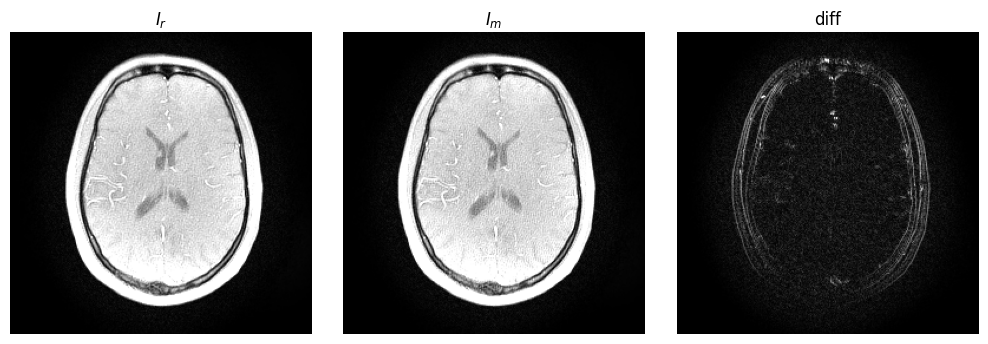

In [18]:
plot(["img_ref","img_mov", "diff"], title=("$I_r$", "$I_m$", "diff"), figsize=10, savepath="fig_brain.pdf", window=0.3)

### 3.2 Rigid Registration

In [19]:
%%bash

bart affinereg -R img_ref img_mov aff

L-BFGS iter 0: obj: -1.429350e+00!
L-BFGS iter 1: obj: -1.464751e+00!
L-BFGS converged after 2 iterations with fopt=-1.464829e+00
L-BFGS iter 0: obj: -1.265204e+00!
L-BFGS iter 1: obj: -1.266102e+00!
L-BFGS iter 2: obj: -1.266815e+00!
L-BFGS iter 3: obj: -1.269504e+00!
L-BFGS iter 4: obj: -1.272707e+00!
L-BFGS iter 5: obj: -1.275247e+00!
L-BFGS iter 6: obj: -1.276976e+00!
L-BFGS iter 7: obj: -1.278114e+00!
L-BFGS iter 8: obj: -1.278779e+00!
L-BFGS iter 9: obj: -1.279282e+00!
L-BFGS iter 10: obj: -1.279537e+00!
L-BFGS iter 11: obj: -1.279704e+00!
L-BFGS converged after 12 iterations with fopt=-1.279827e+00
L-BFGS iter 0: obj: -1.048234e+00!
L-BFGS iter 1: obj: -1.048414e+00!
L-BFGS converged after 2 iterations with fopt=-1.048440e+00
Affine Transform Matrix:
  +1.00e+00  -8.11e-03  +0.00e+00  -1.79e-04
  +8.11e-03  +1.00e+00  +0.00e+00  -2.08e-03
  +0.00e+00  +0.00e+00  +1.00e+00  +0.00e+00
Freed 11864456 bytes.


### 3.3 Interpolation in Image Space

In [20]:
%%bash

IMG_FLAGS=$(bart bitmask 0 1 2)

bart interpolate -A $IMG_FLAGS img_mov aff img_mov_int
bart saxpy -- -1 img_ref img_mov_int diff_int


Freed 0 bytes.


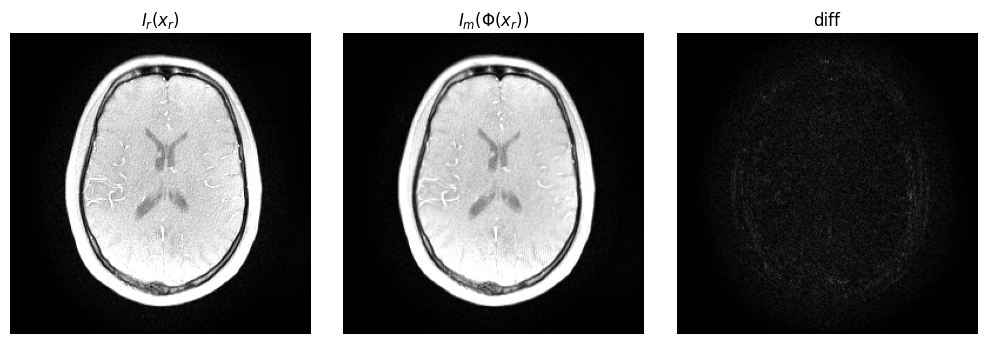

In [21]:
plot(["img_ref","img_mov_int", "diff_int"], title=(r"$I_r(x_r)$", r"$I_m(\Phi(x_r))$", "diff"), figsize=10, savepath="fig_brain_cor.pdf", window=0.3)

### 3.4 Correction in k-Space

In [22]:
%%bash

#This script uses bart fovshift shift and rotates the trajectory with bart fmac
$BART_TOOLBOX_PATH/scripts/affine_kspace.sh ksp_mov trj aff ksp_cor trj_cor

bart nlinv -i12 -S -t trj_cor ksp_cor img_mov_cor col_mov_cor
bart saxpy -- -1 img_ref img_mov_cor diff_cor


Est. image size: 256 256 1
ksp : [  1 512 1597  16   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [256 256   1  16   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 512 1597   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
wgh : [  1 512 1597   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
NUFFT: Toeplitz mode

Model created (non Cartesian, nufft-based):
kspace:     [  1 512 1597  16   1   1   1   1   1   1   1   1   1   1   1   1 ]
images:     [256 256   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
coils:      [256 256   1  16   1   1   1   1   1   1   1   1   1   1   1   1 ]
trajectory: [  3 512 1597   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
pattern:    [  1 512 1597   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
coilimg:    [256 256   1  16   1   1   1   1   1   1   1   1   1   1   1   1 ]

NUFFT: Toeplitz mode
ksp : [  1 512 1597   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [256 256   1   1   1   1   1   1 

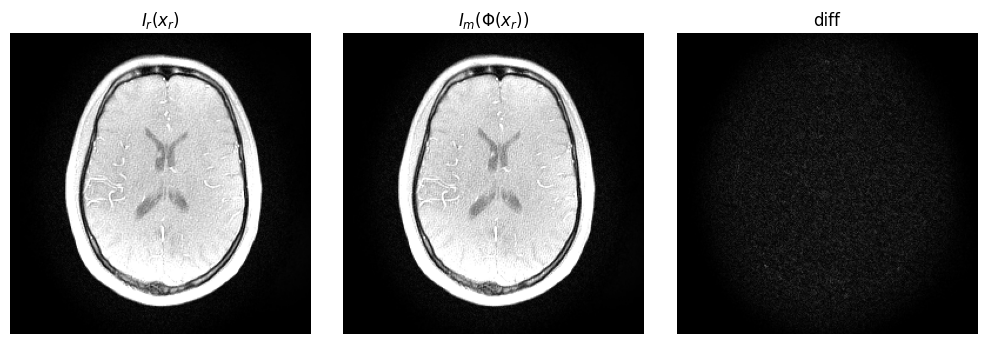

In [23]:
plot(["img_ref","img_mov_cor", "diff_cor"], title=(r"$I_r(x_r)$", r"$I_m(\Phi(x_r))$", "diff"), figsize=10, savepath="fig_brain_cor_ksp.pdf", window=0.3)

## 4 Non-rigid motion fields for PICS

0. Understand the data
1. Prepare data from RAGA measurement
2. Self-gating with SSA-FARY
3. Sensitivity estimation with NLINV (ncalib)
4. Motion-resolved GRASP reconstruction (pics)
5. Estimation of motion fields (estmotion)
6. Motion-compensated reconstruction (pics)



### 4.0 Understand the data

In [24]:
!wget -nc -O ksp_lung.hdr https://zenodo.org/record/13585332/files/ksp_lung.hdr
!wget -nc -O ksp_lung.cfl https://zenodo.org/record/13585332/files/ksp_lung.cfl

!bart show -m ksp_lung

File ‘ksp_lung.hdr’ already there; not retrieving.
File ‘ksp_lung.cfl’ already there; not retrieving.
Type: complex float
Dimensions: 16
AoD:	1	512	1597	24	1	1	1	1	1	1	10	1	1	1	1	1


In [16]:
%%bash

bart traj -R90 -x 512 -D -y 1597 _trj
bart repmat 10 10 _trj trj

In [17]:
%%bash

bart -l$(bart bitmask 10) nufft -i -t trj ksp_lung cim

bart rss 8 cim img

Est. image size: 512x512x1
ksp : [  1 512 1597  24   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [512 512   1  24   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 512 1597   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
NUFFT: Toeplitz mode
ksp : [  1 512 1597   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [512 512   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 512 1597   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
lsqr: add GPU wrapper
	 cg:  50
Done.
Freed 807859084 bytes.


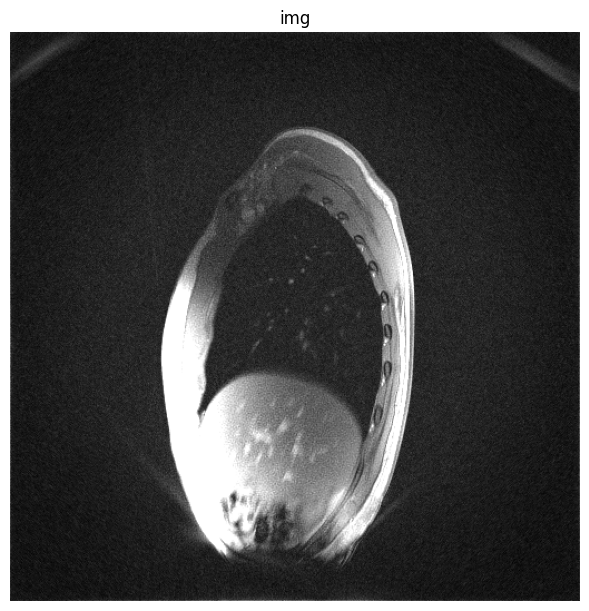

In [27]:
plot(["img"], figsize=6, window=0.2)

### 4.1 Prepare data from RAGA measurement

For more details, see the publication:

*Scholand, N., Schaten, P., Graf., C. et al.* (2024). **Rational Approximation of Golden Angles: Accelerated Reconstructions for Radial MRI**. MRM

In [28]:
%%bash

# Reorder linearly aranged data to temporal acquisition order

bart raga 1597 idx

bart bin -o idx trj _trj
bart reshape $(bart bitmask 2 10) 1 15970 _trj trj

bart bin -o idx ksp_lung _ksp
bart reshape $(bart bitmask 2 10) 1 15970 _ksp ksp

Golden Ratio Index is set to:	1
Reorder binning...
Reorder binning...


### 4.2 Self-gating with SSA-FARY

For more details, see the publication:

*Rosenzweig, S., Scholand, N., Holme, H. & Uecker, M.* (2020). **Cardiac and Respiratory Self-Gating in Radial MRI using an Adapted Singular Spectrum Analysis (SSA-FARY)**. IEEE TMI.

1. Obtain dc sample from symmetric trajectory (DC is not directly sampled but DC +/- 0.5/FOV)

In [29]:
%%bash

bart fft -i 2 ksp _t1
bart fovshift -p -s0:-0.5:0 _t1 _t2
bart avg 7 _t2 dc


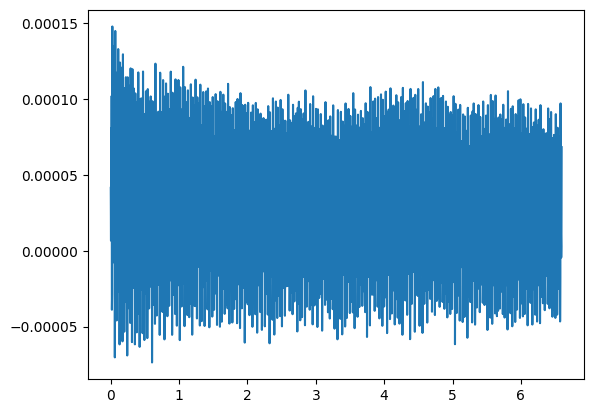

In [30]:
dc = cfl.readcfl("dc").squeeze().real
t = np.array(range(dc.shape[1]))*0.0033
plt.plot(t[:2000], dc[0,:2000])
plt.show()

2. Remove harmonics of angular frequency

In [31]:
%%bash

bart rmfreq trj dc dc_rm

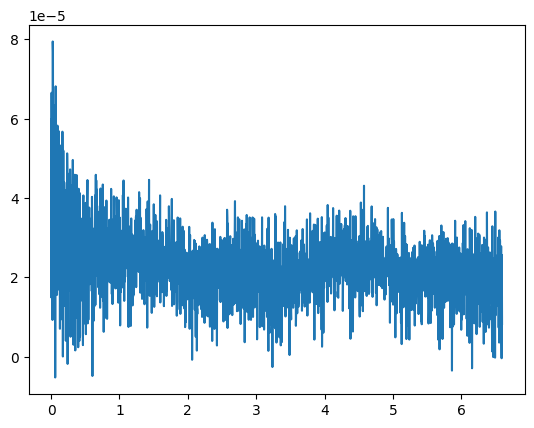

In [32]:
dc = cfl.readcfl("dc_rm").squeeze().real
t = np.array(range(dc.shape[1]))*0.0033
plt.plot(t[:2000], dc[0,:2000])
plt.show()

3. Average 10 consequtive spokes to speed up computation

In [33]:
%%bash

bart reshape $(bart bitmask 2 10) 10 1597 dc_rm _dc_rm
bart avg $(bart bitmask 2) _dc_rm dc_low

bart squeeze dc_low _dc
bart transpose 0 1 _dc dc_low

4. Make real and imaginary part independent channels

In [34]:
%%bash

bart creal dc_low dc_real
bart scale -- -1i dc_low dci
bart creal dci dc_imag
bart join 1 dc_real dc_imag self_nav

loading dc_real
loading dc_imag
done copying file 0
done copying file 1


5. SSA-FARY

In [35]:
%%bash

bart ssa -w 75 self_nav EOF
bart transpose 1 11 EOF _tmp
bart transpose 0 10 _tmp eof

Performing SSA-FARY


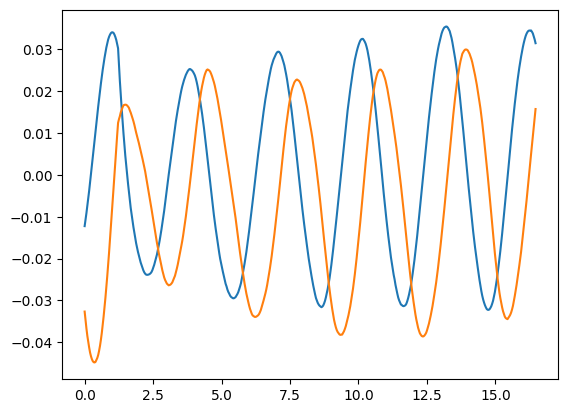

In [36]:
eof = cfl.readcfl("eof").squeeze().real
t = np.array(range(eof.shape[1]))*0.033
plt.plot(t[:500], eof[:500,0])
plt.plot(t[:500], eof[:500,1])
plt.show()

6. Binning

In [37]:
%%bash

bart reshape $(bart bitmask 1 2 10) 5120 1 1597 trj _trj
bart reshape $(bart bitmask 1 2 10) 5120 1 1597 ksp _ksp

bart bin -R15 -C1 -a350 eof _ksp _ksg
bart bin -R15 -C1 -a350 eof _trj _tsg

bart reshape $(bart bitmask 1 2) 512 $(bart show -d 2 _tsg)0 _tsg tsg
bart reshape $(bart bitmask 1 2) 512 $(bart show -d 2 _ksg)0 _ksg ksg

bart show -m ksg

Quadrature binning...
Quadrature binning...
Type: complex float
Dimensions: 16
AoD:	1	512	1130	24	1	1	1	1	1	1	1	15	1	1	1	1


### 4.3 Sensitivity estimation with NLINV (ncalib)

NLINV is a method to jointly estimate sensitivity maps and images from (potentially non-Cartesian) k-space data. ncalib is a wrapper for NLINV estimating the sensitivity maps low frequency k-space data.

In [38]:
%%bash

bart -l$(bart bitmask 10 11) -r ksg ncalib -x512:512:1 --cgiter=25 -i10 -t tsg ksg col

#normalize the coil sensitivity maps to pixel-wise unit norm
COIL_FLAG=$(bart bitmask 3)
bart normalize $COIL_FLAG col coln

ksp : [  1 512 1130  24   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [ 48  48   1  24   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 512 1130   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
wgh : [  1 512 1130   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
NUFFT: low-mem mode
NUFFT: Toeplitz mode

Model created (non Cartesian, nufft-based):
kspace:     [  1 512 1130  24   1   1   1   1   1   1   1   1   1   1   1   1 ]
images:     [ 48  48   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
coils:      [ 16  16   1  24   1   1   1   1   1   1   1   1   1   1   1   1 ]
trajectory: [  3 512 1130   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
pattern:    [  1 512 1130   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
mask:       [  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
coilimg:    [ 48  48   1  24   1   1   1   1   1   1   1   1   1   1   1   1 ]

NUFFT: Toeplitz mode
ksp : [  1 512 1130   1   1   1   1   1  

### 4.4 Motion-resolved GRASP reconstruction (pics)

$$
(x_1, \dots, x_T) = \arg\min_x \sum_{t=1}^{T=15}\lVert \mathcal{PFC}_tx_t - y_t\rVert^2 + \lambda \sum_{t=1}^{T=15} \lVert x_t - x_{t-1} \rVert_1 + \sum_{t=1}^{T=15} TV_{spatial}(x_t)
$$

In [39]:
%%bash

export $(bart version -V)
if [ $CUDA -eq 1 ] && [ $BART_GPU -eq 1 ] ;then
  GPU=" --gpu-gridding"
else
  GPU=
fi

IMG_FLAGS=$(bart bitmask 0 1)
TIME_FLAG=$(bart bitmask 11)

bart pics -S -i100 $GPU -RT:$IMG_FLAGS:0:0.00001 -RT:$TIME_FLAG:0:0.01 -t tsg ksg coln img_mres

GPU reconstruction
[  1 512 1130  24   1   1   1   1   1   1   1  15   1   1   1   1 ]
[512 512   1  24   1   1   1   1   1   1   1  15   1   1   1   1 ]
ksp : [  1 512 1130  24   1   1   1   1   1   1   1  15   1   1   1   1 ]
cim : [512 512   1  24   1   1   1   1   1   1   1  15   1   1   1   1 ]
traj: [  3 512 1130   1   1   1   1   1   1   1   1  15   1   1   1   1 ]
wgh : [  1 512 1130   1   1   1   1   1   1   1   1  15   1   1   1   1 ]
NUFFT: Toeplitz mode
ksp : [  1 512 1130   1   1   1   1   1   1   1   1  15   1   1   1   1 ]
cim : [512 512   1   1   1   1   1   1   1   1   1  15   1   1   1   1 ]
traj: [  3 512 1130   1   1   1   1   1   1   1   1  15   1   1   1   1 ]
wgh : [  1 512 1130   1   1   1   1   1   1   1   1  15   1   1   1   1 ]
Scaling: 0.020900! (max = 0.020900/p90 = 0.005502/median = 0.000973)
Inverse scaling of the data: 0.020900
TV regularization: 0.000010
TV regularization: 0.010000
Regularization terms: 2, Supporting variables: 0
ADMM
lsqr: add GPU wrap

In [40]:
%%bash

bart show -m img_mres

Type: complex float
Dimensions: 16
AoD:	512	512	1	1	1	1	1	1	1	1	1	15	1	1	1	1


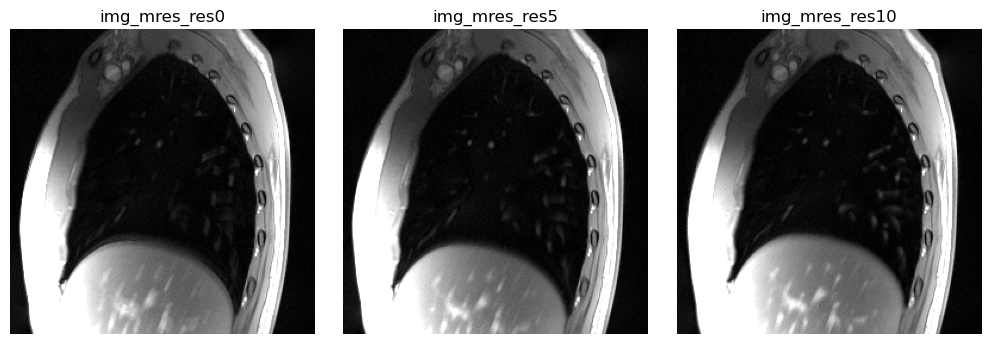

In [31]:
!bart extract 0 128 384 1 128 384 11 0 1 img_mres img_mres_res0
!bart extract 0 128 384 1 128 384 11 5 6 img_mres img_mres_res5
!bart extract 0 128 384 1 128 384 11 10 11 img_mres img_mres_res10

plot(["img_mres_res0","img_mres_res5","img_mres_res10"], window=0.2, savepath="img_mres.pdf", figsize=10)

### 4.5 Estimation of motion fields (estmotion)

In [41]:
%%bash

bart slice 11 0 img_mres img_ref

IMG_FLAGS=$(bart bitmask 0 1)

bart -l$(bart bitmask 11) -r img_mres estmotion -l4 $IMG_FLAGS img_ref img_mres mot imot

bart interpolate -D $IMG_FLAGS img_mres mot img_int

Generate Gaussian Pyramide:
	Level 0: sigma=0.000000, dims=[512 512   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
	Level 1: sigma=2.000000, dims=[256 256   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
	Level 2: sigma=4.000000, dims=[128 128   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
	Level 3: sigma=8.000000, dims=[ 64  64   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Optimizing level 3
Loss[0]: -4.083880e+03
Loss[1]: -4.085343e+03
Loss[2]: -4.086748e+03
Loss[3]: -4.087819e+03
Loss[4]: -4.088621e+03
Loss[5]: -4.089238e+03
Loss[6]: -4.089734e+03
Loss[7]: -4.090167e+03
Loss[8]: -4.090534e+03
Loss[9]: -4.090858e+03
Loss[10]: -4.091143e+03
Loss[11]: -4.091407e+03
Loss[12]: -4.091648e+03
Loss[13]: -4.091836e+03
Loss[14]: -4.091977e+03
Loss[15]: -4.092096e+03
Loss[16]: -4.092203e+03
Loss[17]: -4.092300e+03
Loss[18]: -4.092386e+03
Loss[19]: -4.092463e+03
Loss[20]: -4.092527e+03
Loss[21]: -4.092580e+03
Loss[22]: -4.092618e+03
Loss[23]: -4.092652

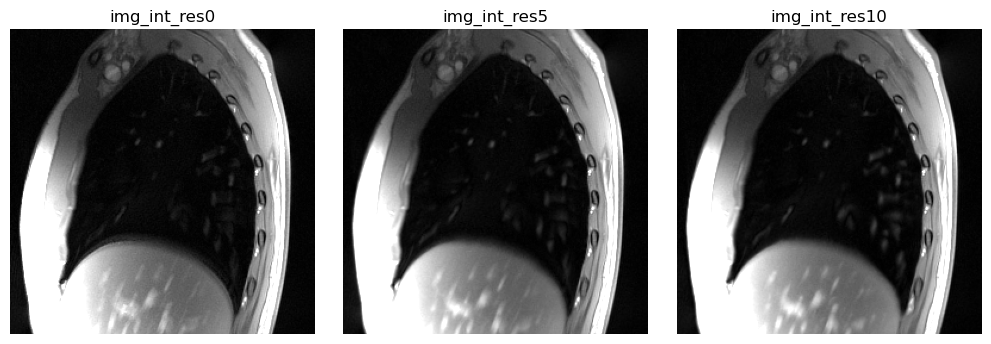

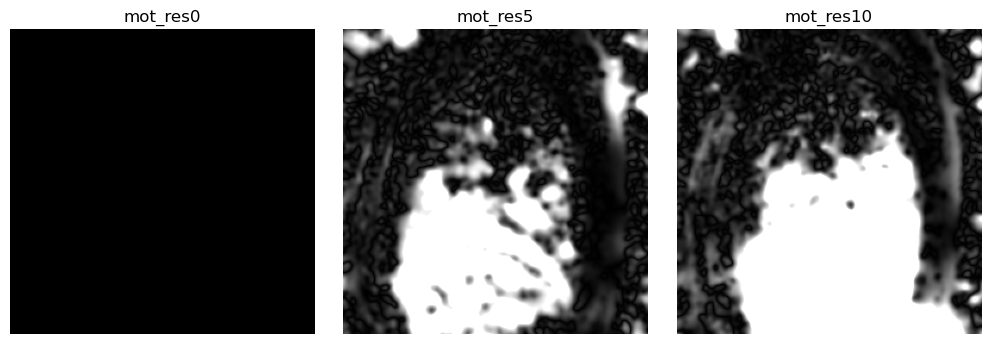

In [33]:
!bart extract 0 128 384 1 128 384 11 0 1 img_int img_int_res0
!bart extract 0 128 384 1 128 384 11 5 6 img_int img_int_res5
!bart extract 0 128 384 1 128 384 11 10 11 img_int img_int_res10

plot(["img_int_res0","img_int_res5","img_int_res10"], window=0.2, savepath="img_int.pdf", figsize=10)

!bart extract 0 128 384 1 128 384 8 0 1 11 0 1 mot mot_res0
!bart extract 0 128 384 1 128 384 8 0 1 11 5 6 mot mot_res5
!bart extract 0 128 384 1 128 384 8 0 1 11 10 11 mot mot_res10

plot(["mot_res0","mot_res5","mot_res10"], window=0.2, savepath="mot.pdf", figsize=10)

### 4.6 Motion-compensated reconstruction (pics)

$$
(x_1, \dots, x_T) = \arg\min_x \sum_{t=1}^{T=15}\lVert \mathcal{PFC}_t\Phi_t x_t - y_t\rVert^2 + \lambda \sum_{t=1}^{T=15} \lVert x_t - x_{t-1} \rVert_1 + \sum_{t=1}^{T=15} TV_{spatial}(x_t)
$$

$$
x = \arg\min_x \sum_{t=1}^{T=15}\lVert \mathcal{PFC}_t\Phi_t x - y_t\rVert^2 + TV_{spatial}(x)
$$

In [34]:
%%bash

export $(bart version -V)
if [ $CUDA -eq 1 ] && [ $BART_GPU -eq 1 ] ;then
  GPU=" --gpu-gridding"
else
  GPU=
fi

IMG_FLAGS=$(bart bitmask 0 1)
TIME_FLAG=$(bart bitmask 11)

bart pics -S -i100 $GPU -RT:$IMG_FLAGS:0:0.00001 --motion-field=imot -RT:$TIME_FLAG:0:0.01        -t tsg ksg coln img_imoco_TV
bart pics -S -i100 $GPU -RT:$IMG_FLAGS:0:0.00001 --motion-field=imot --shared-img-dims=$TIME_FLAG -t tsg ksg coln img_imoco


GPU reconstruction
[  1 512 1130  24   1   1   1   1   1   1   1  15   1   1   1   1 ]
[512 512   1  24   1   1   1   1   1   1   1  15   1   1   1   1 ]
ksp : [  1 512 1130  24   1   1   1   1   1   1   1  15   1   1   1   1 ]
cim : [512 512   1  24   1   1   1   1   1   1   1  15   1   1   1   1 ]
traj: [  3 512 1130   1   1   1   1   1   1   1   1  15   1   1   1   1 ]
wgh : [  1 512 1130   1   1   1   1   1   1   1   1  15   1   1   1   1 ]
NUFFT: Toeplitz mode
ksp : [  1 512 1130   1   1   1   1   1   1   1   1  15   1   1   1   1 ]
cim : [512 512   1   1   1   1   1   1   1   1   1  15   1   1   1   1 ]
traj: [  3 512 1130   1   1   1   1   1   1   1   1  15   1   1   1   1 ]
wgh : [  1 512 1130   1   1   1   1   1   1   1   1  15   1   1   1   1 ]
Scaling: 0.024890! (max = 0.024890/p90 = 0.005440/median = 0.000967)
Inverse scaling of the data: 0.024890
TV regularization: 0.000010
TV regularization: 0.010000
Regularization terms: 2, Supporting variables: 0
ADMM
lsqr: add GPU wrap

### 4.7 Visualization

In [43]:
%%bash

bart extract 0 128 384 1 128 384 11 0 1 img_mres img_mres_res
bart extract 0 128 384 1 128 384 11 0 1 img_int img_int_res
bart extract 0 128 384 1 128 384 11 0 1 img_imoco_TV img_imoco_TV_res
bart extract 0 128 384 1 128 384 11 0 1 img_imoco img_imoco_res


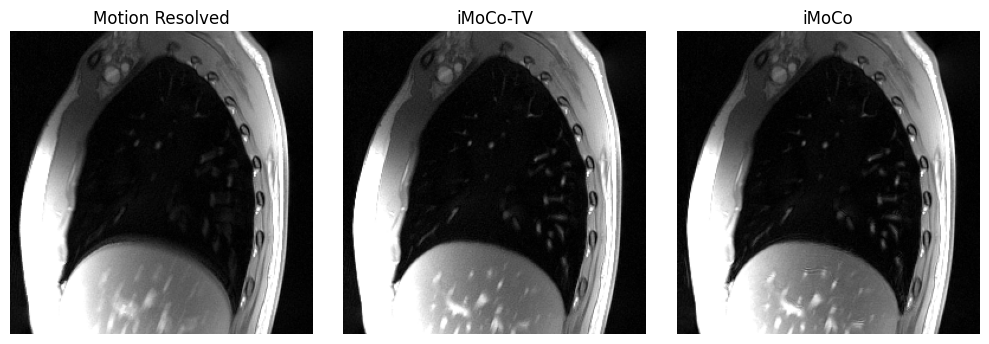

In [44]:
plot(["img_mres_res","img_imoco_TV_res","img_imoco_res"], title=["Motion Resolved", "iMoCo-TV", "iMoCo"], window=0.2, savepath="iMoCo.pdf", figsize=10)